# 作业1: 基于DNN的新冠病例预测 (回归)

使用深度神经网络（DNN）对COVID-19阳性病例进行回归预测。

本代码基于PDF原始版本，仅修正特征选择错误。

## 1. 数据声明

In [15]:
tr_path = '../Data/covid.train.csv'  # 训练数据

## 2. 使用包声明

In [16]:
# PyTorch
import torch
import torch.nn as nn  # 神经网络
from torch.utils.data import Dataset, DataLoader  # 数据集相关

# For data preprocess
import numpy as np  # 矩阵运算，用于计算梯度、更新神经网络等。
import csv  # 数据表格的读写
import os  # 系统驱动函数

# 绘图相关
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# 设置随机种子
myseed = 42069  # 随机种子
torch.backends.cudnn.deterministic = True  # 采用确定的算法
torch.backends.cudnn.benchmark = False  # 采用默认算法
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():  # 如果使用显卡，则为显卡设置随机种子
    torch.cuda.manual_seed_all(myseed)

## 3. 函数定义

In [17]:
def get_device():
    '''Get device info (prioritize GPU)'''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    '''Plot learning curve (loss curve)'''
    total_steps = len(loss_record['train'])  # Number of training steps
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]  # Record dev loss every epoch
    # One Batch equals one Training step
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='Train')  # Training dataset
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='Validation')  # Validation dataset
    plt.ylim(0.0, 5.)  # Constrain y-axis range
    plt.xlabel('Training Steps')
    plt.ylabel('MSE Loss')
    plt.title('Learning Curve of {}'.format(title))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    '''Plot neural network accuracy'''
    if preds is None or targets is None:
        model.eval()  # Set model to evaluation mode
        preds, targets = [], []
        for x, y in dv_set:  # Validation dataset
            x, y = x.to(device), y.to(device)  # Move to device
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='red', alpha=0.6, s=20)
    plt.plot([-0.2, lim], [-0.2, lim], c='blue', linewidth=2, label='Perfect Prediction')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('Ground Truth Value')
    plt.ylabel('Predicted Value')
    plt.title('Ground Truth vs. Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 4. 数据处理

三种类型的数据:
- train : 训练数据集
- dev : 验证数据集  
- test : 测试训练集 (无y的值)

### 4.1 Dataset

类 COVID19Dataset 的功能为:
- 读取 .csv 文件
- 提取数据属性（特征）
- 将 covid.train.csv 分为训练数据集、验证数据集
- 归一化数据属性

TODO1: 实现读取第57、75列

In [18]:
class COVID19Dataset(Dataset):
    '''处理COVID19数据集的dataset类'''
    def __init__(self, path, mode='train', target_only=False, norm_stats=None):
        self.mode = mode
        
        # 读取数据至numpy数组
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:  # 使用所有可用特征
            if mode == 'test':
                # 测试集：使用所有93列作为特征
                feats = list(range(93))
            else:
                # 训练集：使用前93列作为特征（排除最后的目标列）
                feats = list(range(93))
        else:  # TODO1模式：只使用两个tested_positive列
            if mode == 'test':
                # 测试集中前两天的tested_positive位置
                feats = [58, 76]  # 第59列和第77列（0-based索引）
            else:
                # 训练集中前两天的tested_positive位置
                feats = [58, 76]  # 第59列和第77列（0-based索引）
        
        if mode == 'test':
            # 测试数据集：93列特征
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
            
            # 测试集使用训练集的归一化参数
            if not target_only and norm_stats is not None:
                train_mean, train_std = norm_stats
                self.data[:, 40:] = (self.data[:, 40:] - train_mean) / train_std
                
        else:
            # 训练数据集 (训练/验证)：94列总共，93列特征+1列目标
            target = data[:, -1]  # 最后一列是要预测的tested_positive
            data = data[:, feats]  # 使用对应的特征列
            
            # 将训练数据分为训练、验证数据集，即train & dev
            if mode == 'train':  # 训练
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':  # 验证
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # 将数据转换为PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])
            
            # 归一化数据 - 只在训练模式下计算统计参数
            if not target_only:
                if mode == 'train':
                    # 训练集：计算并保存归一化参数
                    self.train_mean = self.data[:, 40:].mean(dim=0, keepdim=True)
                    self.train_std = self.data[:, 40:].std(dim=0, keepdim=True)
                    self.data[:, 40:] = (self.data[:, 40:] - self.train_mean) / self.train_std
                elif mode == 'dev' and norm_stats is not None:
                    # 验证集：使用训练集的归一化参数
                    train_mean, train_std = norm_stats
                    self.data[:, 40:] = (self.data[:, 40:] - train_mean) / train_std
        
        self.dim = self.data.shape[1]
        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    
    def get_norm_stats(self):
        '''返回训练集的归一化参数'''
        if hasattr(self, 'train_mean') and hasattr(self, 'train_std'):
            return self.train_mean, self.train_std
        return None
    
    def __getitem__(self, index):
        # 每次返回一个训练数据样本
        if self.mode in ['train', 'dev']:
            # 训练
            return self.data[index], self.target[index]
        else:
            # 测试（没有target）
            return self.data[index]
    
    def __len__(self):
        # 返回数据集的大小
        return len(self.data)

### 4.2 DataLoader

DataLoader 从 Dataset 中提取数据，并组装为Batch.

In [19]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False, norm_stats=None):
    '''构建一个dataset,然后以Batch形式装载进dataloader.'''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only, norm_stats=norm_stats)  # 构建dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)  # 构建dataloader
    return dataloader

## 5. 深度神经网络DNN

TODO2: 网络架构优化
TODO3: L2正则化

In [20]:
class NeuralNet(nn.Module):
    '''深度神经网络'''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        # TODO2: 网络架构优化 (已完成)
        # 改进: 增加网络深度，使用ReLU激活函数
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
        
        # 损失函数：采用均方误差
        self.criterion = nn.MSELoss(reduction='mean')
        
        # L2正则化系数
        self.l2_reg = 0.01
    
    def forward(self, x):
        '''给定输入数据维度 (batch_size X input_dim), 计算网络的输出'''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        '''计算损失函数 - TODO3: L2正则化 (已完成)'''
        mse_loss = self.criterion(pred, target)
        
        # 添加L2正则化惩罚项
        l2_penalty = 0
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 1:  # 只对权重矩阵正则化
                l2_penalty += torch.norm(param, 2) ** 2
        
        total_loss = mse_loss + self.l2_reg * l2_penalty
        return total_loss

## 6. 训练/验证

In [21]:
def train(tr_set, dv_set, model, config, device):
    '''训练DNN'''
    n_epochs = config['n_epochs']  # 最大epochs
    
    # 设置优化器
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    
    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}  # 记录训练、验证误差
    early_stop_cnt = 0
    epoch = 0
    
    while epoch < n_epochs:
        model.train()  # 设置模型为"训练"状态
        for x, y in tr_set:  # 每一个数据样本
            optimizer.zero_grad()  # 梯度归零
            x, y = x.to(device), y.to(device)  # 数据装载至设备 (cpu/cuda)
            pred = model(x)  # 前向计算，得到输出
            mse_loss = model.cal_loss(pred, y)  # 计算误差
            mse_loss.backward()  # 计算梯度 (BP算法)
            optimizer.step()  # 利用优化器，更新模型参数
            loss_record['train'].append(mse_loss.detach().cpu().item())  # 记录误差
        
        # 每个epoch结束, 采用验证数据集测试.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # 若模型改进，即误差减小，则存储模型参数
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                  .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # 保存模型至"save_path"
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1  # 模型没有改进，则激活early stop机制
        
        epoch += 1
        loss_record['dev'].append(dev_mse)  # 记录验证数据集的误差
        
        if early_stop_cnt > config['early_stop']:
            # 若经过 "config['early_stop']" epochs，模型不再改进，则停止训练
            break
    
    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

def dev(dv_set, model, device):
    '''验证'''
    model.eval()  # 将模型调整为测试状态
    total_loss = 0
    for x, y in dv_set:  # 每一组验证数据
        x, y = x.to(device), y.to(device)  # 装载数据至 (cpu/cuda)
        with torch.no_grad():  # 禁用梯度
            pred = model(x)  # 前向计算，得到网络的输出（预测）
            mse_loss = model.cal_loss(pred, y)  # 计算损失
            total_loss += mse_loss.detach().cpu().item() * len(x)  # 损失累加
    total_loss = total_loss / len(dv_set.dataset)  # 求平均值
    return total_loss

## 7. 设置超参数

TODO4: 训练参数优化

In [22]:
# 修正后的配置
config = {
    'n_epochs': 2000,               # 训练epoch数
    'batch_size': 32,             # batch size
    'optimizer': 'Adam',           # 优化器
    'optim_hparas': {             # 优化器超参数
        'lr': 0.001,              # 学习率
        'weight_decay': 0.001     # 添加weight decay
    },
    'early_stop': 2000,            # early stopping
    'save_path': '../models/model.pth'  # 模型保存路径
}

## 8. 装载数据与模型

In [23]:
# 设置特征选择参数
device = get_device()  # 获取当前可用的设备 ('cpu' 或 'cuda')
target_only = False  # 使用所有93个特征

# 先创建训练集，获取归一化参数
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)  # 训练数据
norm_stats = tr_set.dataset.get_norm_stats()  # 获取训练集的归一化参数

# 使用训练集的归一化参数创建验证集和测试集
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only, norm_stats=norm_stats)  # 验证数据

print(f"训练集特征维度: {tr_set.dataset.dim}")
print(f"训练集样本数: {len(tr_set.dataset)}")
print(f"验证集样本数: {len(dv_set.dataset)}")

model = NeuralNet(tr_set.dataset.dim).to(device)  # 创建神经网络模型

Finished reading the train set of COVID19 Dataset (1822 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (203 samples found, each dim = 93)
训练集特征维度: 93
训练集样本数: 1822
验证集样本数: 203


## 9. 开始训练

In [24]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 304.2666)
Saving model (epoch =    2, loss = 221.1426)
Saving model (epoch =    3, loss = 81.4772)
Saving model (epoch =    4, loss = 42.1778)
Saving model (epoch =    5, loss = 32.5842)
Saving model (epoch =    6, loss = 28.3222)
Saving model (epoch =    7, loss = 24.9042)
Saving model (epoch =    8, loss = 21.0691)
Saving model (epoch =    9, loss = 17.9989)
Saving model (epoch =   10, loss = 14.6672)
Saving model (epoch =   11, loss = 11.8173)
Saving model (epoch =   12, loss = 9.7098)
Saving model (epoch =   13, loss = 8.1607)
Saving model (epoch =   14, loss = 6.9920)
Saving model (epoch =   15, loss = 6.2153)
Saving model (epoch =   16, loss = 5.5625)
Saving model (epoch =   17, loss = 5.0484)
Saving model (epoch =   18, loss = 4.7694)
Saving model (epoch =   19, loss = 4.4079)
Saving model (epoch =   20, loss = 4.1499)
Saving model (epoch =   21, loss = 3.9293)
Saving model (epoch =   22, loss = 3.6853)
Saving model (epoch =   23, loss = 3.5321

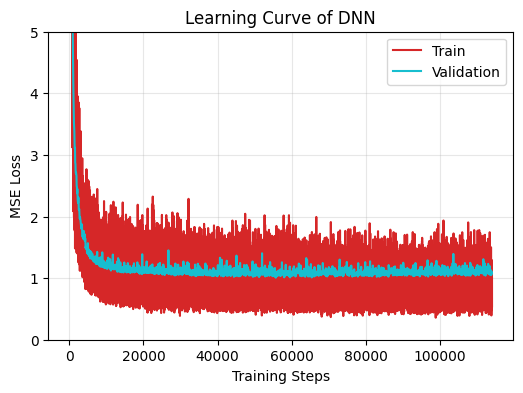

In [25]:
plot_learning_curve(model_loss_record, title='DNN')  # 绘图

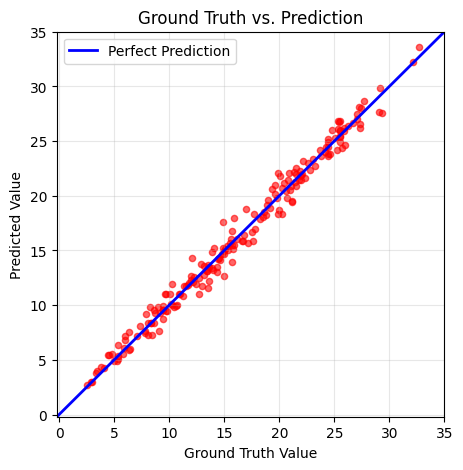

In [26]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)

ckpt = torch.load(config['save_path'], map_location='cpu')  # 加载最佳的模型
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # 绘图：验证集上的预测情况

## 10. 测试和预测

将模型在测试数据集上的预测结果存储于 pred.csv

In [27]:
def test(tt_set, model, device):
    '''测试'''
    model.eval()  # 将模型调整为测试状态
    preds = []
    for x in tt_set:  # 每一组"测试"数据（没有target，即y）
        x = x.to(device)  # 装载数据至 (cpu/cuda)
        with torch.no_grad():  # 禁用梯度
            pred = model(x)  # 前向计算，得到网络的输出（预测）
            preds.append(pred.detach().cpu())  # 记录计算结果
    preds = torch.cat(preds, dim=0).numpy()  # 转换为 numpy array
    return preds

def save_pred(preds, file):
    '''将预测结果存储于指定文件'''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

In [28]:
tt_path = '../Data/covid.test.csv'  # 测试数据路径
# 测试集使用训练集的归一化参数
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only, norm_stats=norm_stats)  # 测试数据

preds = test(tt_set, model, device)  # 预测COVID-19
save_pred(preds, 'pred.csv')  # 将数据存储至pred.csv

Finished reading the test set of COVID19 Dataset (675 samples found, each dim = 93)
Saving results to pred.csv
